# Support Vector Machine - Hourly Taxi Demand Prediction

<hr style="border: 1px solid #8888;">

In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning

#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#import seaborn as sns
#import matplotlib as mlp
import matplotlib.pyplot as plt
#from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.svm import SVR
import math
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from scipy.stats import loguniform
 
from sklearn.model_selection import train_test_split

In [82]:
# import datasets
df_h_comar = pd.read_csv("data/datasets/df_h_comar.csv")
df_h_hexlow = pd.read_csv("data/datasets/df_h_hexlow.csv")
df_h_hexmed = pd.read_csv("data/datasets/df_h_hexmed.csv")
df_h_hexhig = pd.read_csv("data/datasets/df_h_hexhig.csv")

In [84]:
df_h_comar.drop(columns = ['date_start'],inplace = True)
df_h_hexlow.drop(columns = ['date_start'],inplace = True)
df_h_hexmed.drop(columns = ['date_start'],inplace = True)
df_h_hexhig.drop(columns = ['date_start'],inplace = True)

In [87]:
df_h_comar['dayOfWeek'] = df_h_comar['dayOfWeek'].replace(['Monday', 'Tuesday','Wednesday','Thursday',
                                                                  'Friday','Saturday','Sunday'],[0,1,2,3,4,5,6])
df_h_comar['season'] = df_h_comar['season'].replace(['summer', 'winter','spring','autumn'],[0,1,2,3])


df_h_comar

,start_stamp,Pickup_Community_Area,numOfTaxis_area,start_time_hourly,dayOfWeek,isHoliday,isRushhour,start_time_day,start_time_week,start_time_month,pressure,humidity,wind_direction,wind_speed,description,season,temperature_celsius
0,0,1.0,4,0,1,True,False,1,1,1,1024.0,64.0,200.0,4.0,overcast clouds,1,-0.19
1,0,2.0,1,0,1,True,False,1,1,1,1024.0,64.0,200.0,4.0,overcast clouds,1,-0.19
2,0,3.0,43,0,1,True,False,1,1,1,1024.0,64.0,200.0,4.0,overcast clouds,1,-0.19
3,0,4.0,13,0,1,True,False,1,1,1,1024.0,64.0,200.0,4.0,overcast clouds,1,-0.19
4,0,5.0,17,0,1,True,False,1,1,1,1024.0,64.0,200.0,4.0,overcast clouds,1,-0.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227655,23,59.0,1,23,1,False,False,31,1,12,1023.0,89.0,217.0,1.0,mist,1,-11.00
227656,23,60.0,3,23,1,False,False,31,1,12,1023.0,89.0,217.0,1.0,mist,1,-11.00
227657,23,61.0,1,23,1,False,False,31,1,12,1023.0,89.0,217.0,1.0,mist,1,-11.00
227658,23,76.0,3,23,1,False,False,31,1,12,1023.0,89.0,217.0,1.0,mist,1,-11.00


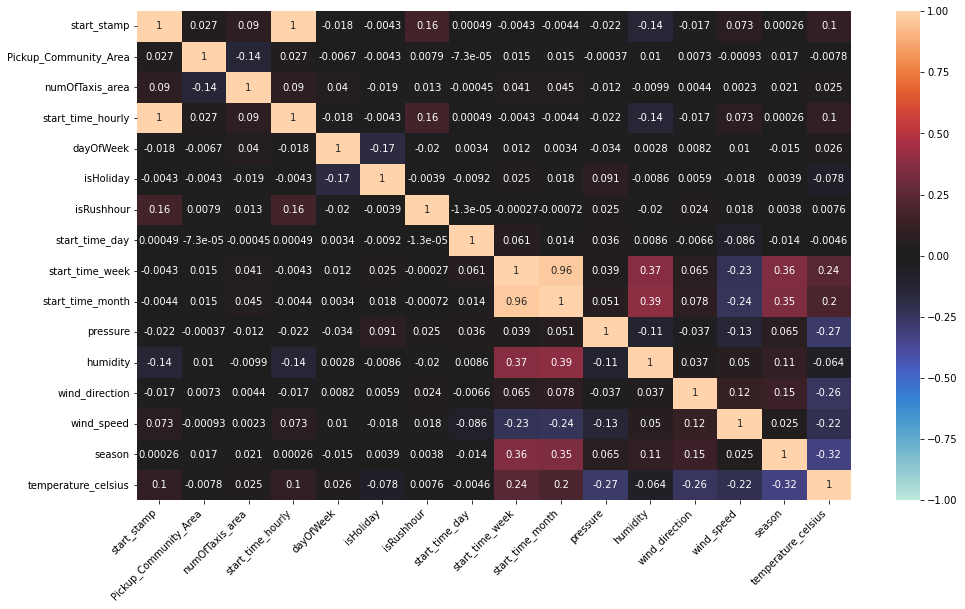

In [88]:
######## make named features like season to 0/1/2/3 so they show up here, before we make them a dummy variable like hours
import seaborn as sns
corr = df_h_comar.corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

#### ISSUMMER ETC ADDEN, user_type, (start_month)

In [ ]:
df_h_hexlow.drop(columns = ['start_time_hourly'],inplace = True)

In [34]:
# defining categorical and numeric features of dfPhiladelphia


categoric = ['start_stamp', 'Pickup_Community_Area','dayOfWeek','start_time_month','start_time_day','start_time_week',
             'isHoliday','description','isRushhour', 'season']
numeric = ['temperature_celsius','wind_speed','wind_direction','humidity','pressure']

In [35]:
# function for normalize numeric and encode categorical features and for create pipeline

def pipeline_for_prediction(categoric, numeric, model):
    
    numeric_transformer = Pipeline(steps=[("standard_scaler", StandardScaler())])
    categorical_transformer = Pipeline(
        steps=[("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("numerical scaler", numeric_transformer, numeric),
            ("one hot encoder", categorical_transformer, categoric),
        ]
    )
    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("model", model)]
    )
    return pipeline

In [36]:
# function for getting different scores for a model

def get_prediction_scores(y_true, y_predicted):
    print("MODEL SCORES:")
    print(f"MAE: {metrics.mean_absolute_error(y_true, y_predicted): .3f}")
    print(f"MSE: {metrics.mean_squared_error(y_true, y_predicted): .3f}")
    print(f"RMSE: {math.sqrt(metrics.mean_squared_error(y_true, y_predicted)): .3f}")
    print(f"Accuracy:", round((1-(metrics.mean_absolute_error(y_true, y_predicted)/df_h_comar["numOfTaxis_area"].mean()))*100,2), "%")
    print(f"R2: {100 * metrics.r2_score(y_true, y_predicted): .3f} %")
    print(f"Max Residual Error: {metrics.max_error(y_true, y_predicted): .3f}")

In [37]:
# function for creating pipeline and fitting model (created by the pipeline), predict and printing scores

def pipeline_fit_predict(reg, categoric, numeric, x_train, y_train, x_val, y_val):
    pipeline = pipeline_for_prediction(categoric, numeric, reg)
    pipeline.fit(x_train, y_train)
    y_predict = pipeline.predict(x_val)
    get_prediction_scores(y_val, y_predict)

In [38]:
# function for finding the best hyperparameter by using RandomizedSearchCV and RepeatedStratifiedKFold
"""parameter:
   - pipeline: used pipeline for grid search (the pipeline contains the model)
   - x_val: data set (features) used for grid search
   - y_val: data set (target value) used for grid search
   - model_par: parameters for which the grid search is done
   - score: used score measure 
   - n_iter: how often grid search will be done
   - n_repeats: how often the data set is randomly splitted (by using the same random hyperparameter) in n_splits
   - n_splits: number of splits in RepeatedStratifiedKFold
   - verbose: getting information during the grid search
"""


from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

def find_best_hyperparameters(pipeline, x_val, y_val, model_par, score, n_iter = 50,  
                                   n_repeats=3, n_splits=5, n_jobs=1, verbose=True): #  n_repeats=3
    
    print(f"Running grid search for the model based on {score}")
    grid_pipeline = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=model_par,
        n_jobs=n_jobs,
        n_iter=n_iter,
        cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42),
        scoring=score,
        random_state=42,
        verbose=verbose,
    )
    grid_pipeline.fit(x_val, y_val)
    print(f"Best {score} Score was: {grid_pipeline.best_score_}")
    print("The best hyper parameters for the model are:")
    print(grid_pipeline.best_params_)

In [39]:
from sklearn.model_selection import train_test_split

def train_val_test(df,testsize=0.3,valsize=0.2):
    
    #split the data set in (1-testsize)% training set and testsize% testing set
    x_train, x_test, y_train, y_test = train_test_split(df.drop('numOfTaxis_area', axis=1)
                                                    , df['numOfTaxis_area'], 
                                                    test_size=testsize,random_state=42)

    # save the combination of training and validation set in extra variables
    x_train_val = x_train
    y_train_val = y_train

    #split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(valsize/(1-testsize)), 
                                                      random_state = 42)
    
    return x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test 

In [40]:
def sampling_already_splitted(x_set, y_set, dependend, num_samples):
    
    y_val_df = y_set.to_frame()
    df = pd.concat([x_set, y_val_df], axis=1)
    df_sample = df.sample(num_samples)
    y_val = df_sample[dependend]
    x_val = df_sample.drop(columns = dependend)
    
    return x_val, y_val

In [41]:
 #split the data set in 70% training set and 30% testing set
    #x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3,random_state=42)
  #  x_train, x_test, y_train, y_test = train_test_split(df_h_comar.drop('numOfTaxis_area', axis=1)
                                  #                  , df_h_comar['numOfTaxis_area'], 
                                   #                 test_size=0.3,random_state=42)

    # save the combination of training and validation set in extra variables
   # x_train_val = x_train
    #y_train_val = y_train

    #split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
    #x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

<hr style="border: 1px solid #8888;">

## Hourly Demand - Community Area

In [42]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = train_val_test(df_h_comar,
                                                                                          testsize=0.3,valsize=0.2)

### Building the model: Checking for the best kernel

#### SVR KERNEL: LINEAR

In [17]:
svr_lin = SVR(kernel = 'linear',verbose = 10,cache_size=15000, max_iter=50000)

In [18]:
pipeline = pipeline_fit_predict(svr_lin, categoric, numeric, x_train_val, y_train_val, x_test, y_test)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -3363473.268517, rho = -11.201561
nSV = 95981, nBSV = 95028


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  23.337
MSE:  4498.339
RMSE:  67.070
Accuracy: 40.8 %
R2:  56.381 %
Max Residual Error:  1446.159


#### SVR KERNEL: POLYNOMIAL WITH DEGREE 2

In [18]:
svr_poly2 = SVR(kernel = 'poly',degree = 2, verbose = 10,cache_size=15000, max_iter=50000)

In [19]:
pipeline = pipeline_fit_predict(svr_poly, categoric, numeric, x_train_val, y_train_val, x_test, y_test)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -4735355.356241, rho = -6.414818
nSV = 99966, nBSV = 99966


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  26.649
MSE:  7286.713
RMSE:  85.362
Accuracy: 32.39 %
R2:  29.343 %
Max Residual Error:  1635.635


#### SVR KERNEL: POLYNOMIAL WITH DEGREE 3

In [13]:
svr_poly3 = SVR(kernel = 'poly',verbose = 10,cache_size=15000, max_iter=50000)

In [14]:
pipeline = pipeline_fit_predict(svr_poly3, categoric, numeric, x_train_val, y_train_val, x_test, y_test)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -5031586.430808, rho = 4.514757
nSV = 99968, nBSV = 99968


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  35.897
MSE:  8870.264
RMSE:  94.182
Accuracy: 8.93 %
R2:  13.987 %
Max Residual Error:  1689.392


#### SVR KERNEL: RBF

In [16]:
svr_rbf = SVR(kernel = 'rbf',verbose = 10,cache_size=15000, max_iter=50000)

In [17]:
pipeline = pipeline_fit_predict(svr_rbf, categoric, numeric, x_train_val, y_train_val, x_test, y_test)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -4792854.643942, rho = -6.669636
nSV = 99984, nBSV = 99984


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  26.690
MSE:  7261.736
RMSE:  85.216
Accuracy: 32.29 %
R2:  29.585 %
Max Residual Error:  1634.289


<hr style="border: 0.5px solid #8888;">

### Hyperparameter Tuning for the best model

#### Sampling data for tuning:

In [43]:
x_val, y_val = sampling_already_splitted(x_val, y_val, 'numOfTaxis_area', 5000)

In [44]:
# creating the ranges for model parameter to use in find_best_hyperparameters

model_para = {'model__C':loguniform(1e-1, 1e2),        
                'model__epsilon':loguniform(1e-1, 1e2)}               

In [45]:
svr_lin = SVR(kernel = 'linear',cache_size=15000, max_iter=50000)

In [46]:
pipeline = pipeline_for_prediction(categoric, numeric, svr_lin)

In [47]:
find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_absolute_error', verbose=10)

Running grid search for the model based on neg_mean_absolute_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-69.461 total time=   0.3s
[CV 2/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 2/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-70.931 total time=   0.3s
[CV 3/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 3/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-71.655 total time=   0.3s
[CV 4/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 4/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-69.763 total time=   0.3s
[CV 5/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 5/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-74.893 total time=   0.3s
[CV 6/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.1447600934

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-24.698 total time=   1.1s
[CV 2/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-26.338 total time=   1.1s
[CV 3/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-26.464 total time=   1.1s
[CV 4/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-25.910 total time=   1.1s
[CV 5/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-29.343 total time=   1.1s
[CV 6/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-24.448 total time=   1.1s
[CV 7/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-25.755 total time=   1.1s
[CV 8/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-28.595 total time=   1.1s
[CV 9/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-25.958 total time=   1.1s
[CV 10/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-27.800 total time=   1.1s
[CV 11/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-26.196 total time=   1.1s
[CV 12/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-25.099 total time=   1.1s
[CV 13/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-26.419 total time=   1.1s
[CV 14/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-26.069 total time=   1.1s
[CV 15/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-29.326 total time=   1.1s
[CV 1/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2937538457632829
[CV 1/15; 3/50] END model__C=0.2938027938703535, model__epsilon=0.2937538457632829;, score=-32.829 total time=   1.2s
[CV 2/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2937538457632829
[CV 2/15; 3/50] END model__C=0.2938027938703535, model__epsilon=0.2937538457632829;, score=-33.072 total time=   1.2s
[CV 3/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2937538457632829
[CV 3/15; 3/50] END model__C=0.2938027938703535, model__epsilon=0.2937538457632829;, score=-34.504 total time=   1.2s
[CV 4/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2937538457632829
[CV 4/15; 3/50] END model__C=0.2938027938703535, model__epsilon=0.2937538457632829;, score=-32.644 total time=   1.2s
[CV 5/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-26.645 total time=   0.7s
[CV 2/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-28.110 total time=   0.6s
[CV 3/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-28.180 total time=   0.7s
[CV 4/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-27.544 total time=   0.7s
[CV 5/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-31.494 total time=   0.6s
[CV 6/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-26.414 total time=   0.7s
[CV 7/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-27.795 total time=   0.7s
[CV 8/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-30.163 total time=   0.6s
[CV 9/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-27.792 total time=   0.6s
[CV 10/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-29.987 total time=   0.6s
[CV 11/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-27.820 total time=   0.7s
[CV 12/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-27.030 total time=   0.7s
[CV 13/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-28.267 total time=   0.7s
[CV 14/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-27.821 total time=   0.6s
[CV 15/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-31.627 total time=   0.6s
[CV 1/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV 1/15; 6/50] END model__C=0.115279871282324, model__epsilon=81.23245085588688;, score=-83.676 total time=   0.3s
[CV 2/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV 2/15; 6/50] END model__C=0.115279871282324, model__epsilon=81.23245085588688;, score=-83.840 total time=   0.3s
[CV 3/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV 3/15; 6/50] END model__C=0.115279871282324, model__epsilon=81.23245085588688;, score=-85.029 total time=   0.3s
[CV 4/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV 4/15; 6/50] END model__C=0.115279871282324, model__epsilon=81.23245085588688;, score=-83.227 total time=   0.3s
[CV 5/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-24.120 total time=   2.6s
[CV 2/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-25.658 total time=   2.6s
[CV 3/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-25.770 total time=   2.6s
[CV 4/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-25.096 total time=   2.6s
[CV 5/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-28.511 total time=   2.6s
[CV 6/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-23.842 total time=   2.6s
[CV 7/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-25.043 total time=   2.6s
[CV 8/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-27.957 total time=   2.6s
[CV 9/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-25.386 total time=   2.6s
[CV 10/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-26.962 total time=   2.6s
[CV 11/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-25.669 total time=   2.6s
[CV 12/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-24.493 total time=   2.6s
[CV 13/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-25.685 total time=   2.6s
[CV 14/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-25.327 total time=   2.6s
[CV 15/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-28.601 total time=   2.6s
[CV 1/15; 8/50] START model__C=0.3511356313970407, model__epsilon=0.35498788321965025
[CV 1/15; 8/50] END model__C=0.3511356313970407, model__epsilon=0.35498788321965025;, score=-32.113 total time=   1.2s
[CV 2/15; 8/50] START model__C=0.3511356313970407, model__epsilon=0.35498788321965025
[CV 2/15; 8/50] END model__C=0.3511356313970407, model__epsilon=0.35498788321965025;, score=-32.516 total time=   1.2s
[CV 3/15; 8/50] START model__C=0.3511356313970407, model__epsilon=0.35498788321965025
[CV 3/15; 8/50] END model__C=0.3511356313970407, model__epsilon=0.35498788321965025;, score=-33.781 total time=   1.2s
[CV 4/15; 8/50] START model__C=0.3511356313970407, model__epsilon=0.35498788321965025
[CV 4/15; 8/50] END model__C=0.3511356313970407, model__epsilon=0.35498788321965025;, score=-32.049 total time=   1.2s
[CV 5/15; 8/50] START model__C=0.3511356313970407, model__eps

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-25.819 total time=   1.3s
[CV 2/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-27.429 total time=   1.3s
[CV 3/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-27.869 total time=   1.3s
[CV 4/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-26.380 total time=   1.3s
[CV 5/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-31.259 total time=   1.3s
[CV 6/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-25.962 total time=   1.3s
[CV 7/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-26.845 total time=   1.3s
[CV 8/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-28.986 total time=   1.3s
[CV 9/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-27.187 total time=   1.3s
[CV 10/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-29.906 total time=   1.3s
[CV 11/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-26.670 total time=   1.3s
[CV 12/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-26.520 total time=   1.3s
[CV 13/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-28.153 total time=   1.3s
[CV 14/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-26.651 total time=   1.3s
[CV 15/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-31.197 total time=   1.3s
[CV 1/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-24.311 total time=   1.8s
[CV 2/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-25.803 total time=   1.8s
[CV 3/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-26.017 total time=   1.8s
[CV 4/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-25.139 total time=   1.8s
[CV 5/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-29.210 total time=   1.8s
[CV 6/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-23.881 total time=   1.8s
[CV 7/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-25.276 total time=   1.8s
[CV 8/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-28.071 total time=   1.8s
[CV 9/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-25.723 total time=   1.8s
[CV 10/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-27.678 total time=   1.8s
[CV 11/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-25.737 total time=   1.8s
[CV 12/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-24.703 total time=   1.8s
[CV 13/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-26.096 total time=   1.8s
[CV 14/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-25.345 total time=   1.8s
[CV 15/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-29.223 total time=   1.9s
[CV 1/15; 12/50] START model__C=0.7523742884534856, model__epsilon=1.2562773503807025
[CV 1/15; 12/50] END model__C=0.7523742884534856, model__epsilon=1.2562773503807025;, score=-29.139 total time=   1.1s
[CV 2/15; 12/50] START model__C=0.7523742884534856, model__epsilon=1.2562773503807025
[CV 2/15; 12/50] END model__C=0.7523742884534856, model__epsilon=1.2562773503807025;, score=-30.131 total time=   1.2s
[CV 3/15; 12/50] START model__C=0.7523742884534856, model__epsilon=1.2562773503807025
[CV 3/15; 12/50] END model__C=0.7523742884534856, model__epsilon=1.2562773503807025;, score=-31.092 total time=   1.2s
[CV 4/15; 12/50] START model__C=0.7523742884534856, model__epsilon=1.2562773503807025
[CV 4/15; 12/50] END model__C=0.7523742884534856, model__epsilon=1.2562773503807025;, score=-29.180 total time=   1.2s
[CV 5/15; 12/50] START model__C=0.7523742884534856, model__eps

[CV 10/15; 14/50] END model__C=0.3972110727381912, model__epsilon=3.4890188454913864;, score=-36.338 total time=   0.9s
[CV 11/15; 14/50] START model__C=0.3972110727381912, model__epsilon=3.4890188454913864
[CV 11/15; 14/50] END model__C=0.3972110727381912, model__epsilon=3.4890188454913864;, score=-31.976 total time=   0.9s
[CV 12/15; 14/50] START model__C=0.3972110727381912, model__epsilon=3.4890188454913864
[CV 12/15; 14/50] END model__C=0.3972110727381912, model__epsilon=3.4890188454913864;, score=-32.172 total time=   0.9s
[CV 13/15; 14/50] START model__C=0.3972110727381912, model__epsilon=3.4890188454913864
[CV 13/15; 14/50] END model__C=0.3972110727381912, model__epsilon=3.4890188454913864;, score=-33.904 total time=   0.9s
[CV 14/15; 14/50] START model__C=0.3972110727381912, model__epsilon=3.4890188454913864
[CV 14/15; 14/50] END model__C=0.3972110727381912, model__epsilon=3.4890188454913864;, score=-31.708 total time=   0.9s
[CV 15/15; 14/50] START model__C=0.3972110727381912,

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-24.382 total time=   1.8s
[CV 2/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-25.859 total time=   1.8s
[CV 3/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-26.096 total time=   1.8s
[CV 4/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-25.135 total time=   1.8s
[CV 5/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-29.360 total time=   1.8s
[CV 6/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-23.944 total time=   1.8s
[CV 7/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-25.361 total time=   1.8s
[CV 8/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-28.089 total time=   1.8s
[CV 9/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-25.828 total time=   1.8s
[CV 10/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-27.794 total time=   1.8s
[CV 11/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-25.627 total time=   1.8s
[CV 12/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-24.810 total time=   1.8s
[CV 13/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-26.199 total time=   1.8s
[CV 14/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-25.364 total time=   1.8s
[CV 15/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-29.290 total time=   1.8s
[CV 1/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-24.319 total time=   1.8s
[CV 2/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-25.856 total time=   1.8s
[CV 3/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-26.032 total time=   1.8s
[CV 4/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-25.141 total time=   1.8s
[CV 5/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-29.227 total time=   1.8s
[CV 6/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-23.893 total time=   1.8s
[CV 7/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-25.283 total time=   1.8s
[CV 8/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-28.058 total time=   1.8s
[CV 9/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-25.739 total time=   1.8s
[CV 10/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-27.679 total time=   1.8s
[CV 11/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-25.746 total time=   1.8s
[CV 12/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-24.719 total time=   1.8s
[CV 13/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-26.104 total time=   1.8s
[CV 14/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-25.343 total time=   1.8s
[CV 15/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-29.231 total time=   1.8s
[CV 1/15; 17/50] START model__C=0.15673095467235415, model__epsilon=70.25166339242152
[CV 1/15; 17/50] END model__C=0.15673095467235415, model__epsilon=70.25166339242152;, score=-75.188 total time=   0.4s
[CV 2/15; 17/50] START model__C=0.15673095467235415, model__epsilon=70.25166339242152
[CV 2/15; 17/50] END model__C=0.15673095467235415, model__epsilon=70.25166339242152;, score=-75.491 total time=   0.4s
[CV 3/15; 17/50] START model__C=0.15673095467235415, model__epsilon=70.25166339242152
[CV 3/15; 17/50] END model__C=0.15673095467235415, model__epsilon=70.25166339242152;, score=-76.744 total time=   0.4s
[CV 4/15; 17/50] START model__C=0.15673095467235415, model__epsilon=70.25166339242152
[CV 4/15; 17/50] END model__C=0.15673095467235415, model__epsilon=70.25166339242152;, score=-74.808 total time=   0.4s
[CV 5/15; 17/50] START model__C=0.15673095467235415, model__

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-30.447 total time=   0.8s
[CV 2/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-31.858 total time=   0.8s
[CV 3/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-31.910 total time=   0.8s
[CV 4/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-31.647 total time=   0.8s
[CV 5/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-34.014 total time=   0.8s
[CV 6/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-30.485 total time=   0.8s
[CV 7/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-31.651 total time=   0.8s
[CV 8/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-34.196 total time=   0.8s
[CV 9/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-30.881 total time=   0.8s
[CV 10/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-32.848 total time=   0.8s
[CV 11/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-32.201 total time=   0.8s
[CV 12/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-30.468 total time=   0.8s
[CV 13/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-31.738 total time=   0.8s
[CV 14/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-31.256 total time=   0.8s
[CV 15/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-34.275 total time=   0.8s
[CV 1/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 1/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-28.807 total time=   1.3s
[CV 2/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 2/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-29.826 total time=   1.3s
[CV 3/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-30.738 total time=   1.4s
[CV 4/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 4/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-28.857 total time=   1.3s
[CV 5/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 5/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-34.096 total time=   1.3s
[CV 6/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-28.920 total time=   1.4s
[CV 7/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 7/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-29.421 total time=   1.4s
[CV 8/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 8/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-31.143 total time=   1.4s
[CV 9/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 9/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-29.593 total time=   1.4s
[CV 10/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-33.327 total time=   1.4s
[CV 11/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 11/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-29.231 total time=   1.3s
[CV 12/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-29.393 total time=   1.4s
[CV 13/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-30.979 total time=   1.4s
[CV 14/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-29.009 total time=   1.4s
[CV 15/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 15/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-33.783 total time=   1.3s
[CV 1/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-24.215 total time=   1.5s
[CV 2/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-25.763 total time=   1.5s
[CV 3/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-25.951 total time=   1.5s
[CV 4/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-25.228 total time=   1.5s
[CV 5/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-28.966 total time=   1.5s
[CV 6/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-23.880 total time=   1.5s
[CV 7/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-25.205 total time=   1.5s
[CV 8/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-28.037 total time=   1.5s
[CV 9/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-25.590 total time=   1.5s
[CV 10/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-27.489 total time=   1.5s
[CV 11/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-25.741 total time=   1.5s
[CV 12/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-24.562 total time=   1.5s
[CV 13/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-25.936 total time=   1.5s
[CV 14/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-25.400 total time=   1.5s
[CV 15/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-28.986 total time=   1.5s
[CV 1/15; 21/50] START model__C=0.2323350351539011, model__epsilon=3.0586566669785253
[CV 1/15; 21/50] END model__C=0.2323350351539011, model__epsilon=3.0586566669785253;, score=-33.859 total time=   0.9s
[CV 2/15; 21/50] START model__C=0.2323350351539011, model__epsilon=3.0586566669785253
[CV 2/15; 21/50] END model__C=0.2323350351539011, model__epsilon=3.0586566669785253;, score=-34.117 total time=   0.9s
[CV 3/15; 21/50] START model__C=0.2323350351539011, model__epsilon=3.0586566669785253
[CV 3/15; 21/50] END model__C=0.2323350351539011, model__epsilon=3.0586566669785253;, score=-35.551 total time=   0.9s
[CV 4/15; 21/50] START model__C=0.2323350351539011, model__epsilon=3.0586566669785253
[CV 4/15; 21/50] END model__C=0.2323350351539011, model__epsilon=3.0586566669785253;, score=-33.723 total time=   0.9s
[CV 5/15; 21/50] START model__C=0.2323350351539011, model__e

[CV 10/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-36.194 total time=   0.6s
[CV 11/15; 23/50] START model__C=0.5975027999960293, model__epsilon=9.717775305059629
[CV 11/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-31.904 total time=   0.6s
[CV 12/15; 23/50] START model__C=0.5975027999960293, model__epsilon=9.717775305059629
[CV 12/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-32.228 total time=   0.6s
[CV 13/15; 23/50] START model__C=0.5975027999960293, model__epsilon=9.717775305059629
[CV 13/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-33.711 total time=   0.6s
[CV 14/15; 23/50] START model__C=0.5975027999960293, model__epsilon=9.717775305059629
[CV 14/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-31.956 total time=   0.6s
[CV 15/15; 23/50] START model__C=0.5975027999960293, model__e

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-24.595 total time=   1.6s
[CV 2/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-26.190 total time=   1.6s
[CV 3/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-26.255 total time=   1.6s
[CV 4/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-25.256 total time=   1.6s
[CV 5/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-29.725 total time=   1.6s
[CV 6/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-24.244 total time=   1.6s
[CV 7/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-25.674 total time=   1.6s
[CV 8/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-28.177 total time=   1.6s
[CV 9/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-25.979 total time=   1.6s
[CV 10/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-28.150 total time=   1.6s
[CV 11/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-25.687 total time=   1.6s
[CV 12/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-25.173 total time=   1.6s
[CV 13/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-26.405 total time=   1.6s
[CV 14/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-25.469 total time=   1.6s
[CV 15/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-29.688 total time=   1.6s
[CV 1/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-28.804 total time=   1.0s
[CV 2/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-30.257 total time=   0.9s
[CV 3/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-30.051 total time=   0.9s
[CV 4/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-29.834 total time=   1.0s
[CV 5/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-32.308 total time=   0.9s
[CV 6/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-28.550 total time=   1.0s
[CV 7/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-29.783 total time=   0.9s
[CV 8/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-32.481 total time=   0.9s
[CV 9/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-29.234 total time=   0.9s
[CV 10/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-31.020 total time=   0.9s
[CV 11/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-30.559 total time=   1.0s
[CV 12/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-28.649 total time=   0.9s
[CV 13/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-30.128 total time=   0.9s
[CV 14/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-29.686 total time=   0.9s
[CV 15/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-32.709 total time=   0.9s
[CV 1/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-36.986 total time=   0.5s
[CV 2/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-38.872 total time=   0.5s
[CV 3/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-38.857 total time=   0.5s
[CV 4/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-37.927 total time=   0.5s
[CV 5/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-40.384 total time=   0.5s
[CV 6/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-37.732 total time=   0.5s
[CV 7/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-38.874 total time=   0.5s
[CV 8/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-40.832 total time=   0.5s
[CV 9/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-37.380 total time=   0.5s
[CV 10/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-39.100 total time=   0.5s
[CV 11/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-38.365 total time=   0.5s
[CV 12/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-37.845 total time=   0.5s
[CV 13/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-38.838 total time=   0.5s
[CV 14/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-37.430 total time=   0.5s
[CV 15/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-40.638 total time=   0.5s
[CV 1/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 1/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-42.034 total time=   0.3s
[CV 2/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 2/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-43.858 total time=   0.3s
[CV 3/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 3/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-44.637 total time=   0.3s
[CV 4/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 4/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-43.182 total time=   0.3s
[CV 5/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.2

[CV 10/15; 30/50] END model__C=0.13667272915456222, model__epsilon=0.946217535646149;, score=-39.925 total time=   1.1s
[CV 11/15; 30/50] START model__C=0.13667272915456222, model__epsilon=0.946217535646149
[CV 11/15; 30/50] END model__C=0.13667272915456222, model__epsilon=0.946217535646149;, score=-35.589 total time=   1.1s
[CV 12/15; 30/50] START model__C=0.13667272915456222, model__epsilon=0.946217535646149
[CV 12/15; 30/50] END model__C=0.13667272915456222, model__epsilon=0.946217535646149;, score=-35.705 total time=   1.1s
[CV 13/15; 30/50] START model__C=0.13667272915456222, model__epsilon=0.946217535646149
[CV 13/15; 30/50] END model__C=0.13667272915456222, model__epsilon=0.946217535646149;, score=-37.414 total time=   1.1s
[CV 14/15; 30/50] START model__C=0.13667272915456222, model__epsilon=0.946217535646149
[CV 14/15; 30/50] END model__C=0.13667272915456222, model__epsilon=0.946217535646149;, score=-35.221 total time=   1.1s
[CV 15/15; 30/50] START model__C=0.13667272915456222

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-26.871 total time=   1.3s
[CV 2/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-28.306 total time=   1.3s
[CV 3/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-29.020 total time=   1.3s
[CV 4/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-27.227 total time=   1.3s
[CV 5/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-32.330 total time=   1.3s
[CV 6/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-27.158 total time=   1.3s
[CV 7/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-27.667 total time=   1.3s
[CV 8/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-29.689 total time=   1.3s
[CV 9/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-28.133 total time=   1.3s
[CV 10/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-31.133 total time=   1.3s
[CV 11/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-27.481 total time=   1.3s
[CV 12/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-27.523 total time=   1.3s
[CV 13/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-29.274 total time=   1.3s
[CV 14/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-27.417 total time=   1.3s
[CV 15/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-32.129 total time=   1.3s
[CV 1/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-24.149 total time=   2.3s
[CV 2/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-25.671 total time=   2.3s
[CV 3/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-25.821 total time=   2.3s
[CV 4/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-25.161 total time=   2.3s
[CV 5/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-28.532 total time=   2.3s
[CV 6/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-23.868 total time=   2.3s
[CV 7/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-25.114 total time=   2.3s
[CV 8/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-27.955 total time=   2.3s
[CV 9/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-25.352 total time=   2.3s
[CV 10/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-27.021 total time=   2.3s
[CV 11/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-25.693 total time=   2.3s
[CV 12/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-24.507 total time=   2.3s
[CV 13/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-25.687 total time=   2.3s
[CV 14/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-25.312 total time=   2.3s
[CV 15/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-28.578 total time=   2.3s
[CV 1/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4.247058562261868
[CV 1/15; 33/50] END model__C=0.6963114377829286, model__epsilon=4.247058562261868;, score=-29.710 total time=   0.8s
[CV 2/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4.247058562261868
[CV 2/15; 33/50] END model__C=0.6963114377829286, model__epsilon=4.247058562261868;, score=-30.715 total time=   0.8s
[CV 3/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4.247058562261868
[CV 3/15; 33/50] END model__C=0.6963114377829286, model__epsilon=4.247058562261868;, score=-31.592 total time=   0.9s
[CV 4/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4.247058562261868
[CV 4/15; 33/50] END model__C=0.6963114377829286, model__epsilon=4.247058562261868;, score=-29.828 total time=   0.9s
[CV 5/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4

[CV 11/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-91.341 total time=   0.3s
[CV 12/15; 35/50] START model__C=0.16736010167825777, model__epsilon=91.33995846860967
[CV 12/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-91.302 total time=   0.3s
[CV 13/15; 35/50] START model__C=0.16736010167825777, model__epsilon=91.33995846860967
[CV 13/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-92.498 total time=   0.3s
[CV 14/15; 35/50] START model__C=0.16736010167825777, model__epsilon=91.33995846860967
[CV 14/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-90.893 total time=   0.3s
[CV 15/15; 35/50] START model__C=0.16736010167825777, model__epsilon=91.33995846860967
[CV 15/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-95.019 total time=   0.3s
[CV 1/15; 36/50] START model__C=20.73644517790503, m

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-24.113 total time=   2.4s
[CV 2/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-25.643 total time=   2.3s
[CV 3/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-25.754 total time=   2.3s
[CV 4/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-25.147 total time=   2.3s
[CV 5/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-28.621 total time=   2.4s
[CV 6/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-23.740 total time=   2.4s
[CV 7/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-25.069 total time=   2.4s
[CV 8/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-27.956 total time=   2.4s
[CV 9/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-25.390 total time=   2.4s
[CV 10/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-27.019 total time=   2.4s
[CV 11/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-25.705 total time=   2.4s
[CV 12/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-24.478 total time=   2.4s
[CV 13/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-25.784 total time=   2.4s
[CV 14/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-25.288 total time=   2.3s
[CV 15/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-28.665 total time=   2.4s
[CV 1/15; 37/50] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 1/15; 37/50] END model__C=0.10388823104027935, model__epsilon=27.95015916508335;, score=-47.503 total time=   0.5s
[CV 2/15; 37/50] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 2/15; 37/50] END model__C=0.10388823104027935, model__epsilon=27.95015916508335;, score=-47.781 total time=   0.5s
[CV 3/15; 37/50] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 3/15; 37/50] END model__C=0.10388823104027935, model__epsilon=27.95015916508335;, score=-49.110 total time=   0.5s
[CV 4/15; 37/50] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 4/15; 37/50] END model__C=0.10388823104027935, model__epsilon=27.95015916508335;, score=-47.233 total time=   0.5s
[CV 5/15; 37/50] START model__C=0.10388823104027935, model__epsilo

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-26.945 total time=   0.7s
[CV 2/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-28.486 total time=   0.7s
[CV 3/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-28.492 total time=   0.7s
[CV 4/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-28.105 total time=   0.7s
[CV 5/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-31.225 total time=   0.7s
[CV 6/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-26.730 total time=   0.7s
[CV 7/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-28.042 total time=   0.7s
[CV 8/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-30.687 total time=   0.7s
[CV 9/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-27.890 total time=   0.7s
[CV 10/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-29.943 total time=   0.7s
[CV 11/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-28.353 total time=   0.7s
[CV 12/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-27.249 total time=   0.7s
[CV 13/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-28.457 total time=   0.7s
[CV 14/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-28.115 total time=   0.7s
[CV 15/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-31.548 total time=   0.7s
[CV 1/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-24.132 total time=   2.4s
[CV 2/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-25.661 total time=   2.4s
[CV 3/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-25.784 total time=   2.4s
[CV 4/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-25.129 total time=   2.4s
[CV 5/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-28.622 total time=   2.4s
[CV 6/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-23.739 total time=   2.4s
[CV 7/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-25.089 total time=   2.4s
[CV 8/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-27.944 total time=   2.5s
[CV 9/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-25.423 total time=   2.5s
[CV 10/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-26.980 total time=   2.5s
[CV 11/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-25.678 total time=   2.4s
[CV 12/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-24.481 total time=   2.5s
[CV 13/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-25.802 total time=   2.5s
[CV 14/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-25.344 total time=   2.4s
[CV 15/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-28.685 total time=   2.5s
[CV 1/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-27.367 total time=   1.4s
[CV 2/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-28.830 total time=   1.4s
[CV 3/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-29.487 total time=   1.4s
[CV 4/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-27.742 total time=   1.4s
[CV 5/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-32.839 total time=   1.4s
[CV 6/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-27.616 total time=   1.4s
[CV 7/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677
[CV 7/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-28.133 total time=   1.4s
[CV 8/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-30.138 total time=   1.4s
[CV 9/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-28.621 total time=   1.4s
[CV 10/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-31.887 total time=   1.4s
[CV 11/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-27.838 total time=   1.4s
[CV 12/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-28.012 total time=   1.4s
[CV 13/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-29.761 total time=   1.4s
[CV 14/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-28.024 total time=   1.4s
[CV 15/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-32.681 total time=   1.4s
[CV 1/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-25.054 total time=   1.3s
[CV 2/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-26.624 total time=   1.3s
[CV 3/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-26.628 total time=   1.3s
[CV 4/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-26.066 total time=   1.3s
[CV 5/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-29.267 total time=   1.3s
[CV 6/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-24.794 total time=   1.3s
[CV 7/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-25.922 total time=   1.3s
[CV 8/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-28.817 total time=   1.3s
[CV 9/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-26.094 total time=   1.3s
[CV 10/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-27.825 total time=   1.3s
[CV 11/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-26.537 total time=   1.3s
[CV 12/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-25.384 total time=   1.3s
[CV 13/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-26.502 total time=   1.3s
[CV 14/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-26.312 total time=   1.3s
[CV 15/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-29.350 total time=   1.3s
[CV 1/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748
[CV 1/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-28.080 total time=   1.4s
[CV 2/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-29.245 total time=   1.4s
[CV 3/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-30.075 total time=   1.4s
[CV 4/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748
[CV 4/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-28.316 total time=   1.4s
[CV 5/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-33.380 total time=   1.4s
[CV 6/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748
[CV 6/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-28.190 total time=   1.4s
[CV 7/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-28.722 total time=   1.4s
[CV 8/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-30.599 total time=   1.4s
[CV 9/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-29.071 total time=   1.4s
[CV 10/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748
[CV 10/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-32.574 total time=   1.4s
[CV 11/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-28.517 total time=   1.4s
[CV 12/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-28.604 total time=   1.4s
[CV 13/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-30.384 total time=   1.4s
[CV 14/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-28.472 total time=   1.4s
[CV 15/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748
[CV 15/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-33.214 total time=   1.4s
[CV 1/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-28.647 total time=   1.2s
[CV 2/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-29.705 total time=   1.2s
[CV 3/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 3/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-30.625 total time=   1.2s
[CV 4/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-28.771 total time=   1.2s
[CV 5/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-33.954 total time=   1.2s
[CV 6/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 6/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-28.775 total time=   1.2s
[CV 7/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 7/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-29.251 total time=   1.2s
[CV 8/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-30.992 total time=   1.2s
[CV 9/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 9/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-29.459 total time=   1.2s
[CV 10/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 10/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-33.198 total time=   1.2s
[CV 11/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 11/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-29.045 total time=   1.2s
[CV 12/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 12/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-29.213 total time=   1.2s
[CV 13/15; 43/50] START model__C=0.8569331925053982, mo

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-30.873 total time=   1.2s
[CV 14/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 14/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-28.897 total time=   1.2s
[CV 15/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-33.671 total time=   1.2s
[CV 1/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-25.067 total time=   1.0s
[CV 2/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-26.757 total time=   1.0s
[CV 3/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-26.782 total time=   0.9s
[CV 4/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-26.174 total time=   1.0s
[CV 5/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-29.685 total time=   0.9s
[CV 6/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-24.848 total time=   1.0s
[CV 7/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-26.106 total time=   0.9s
[CV 8/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-28.901 total time=   1.0s
[CV 9/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-26.381 total time=   1.0s
[CV 10/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-28.128 total time=   0.9s
[CV 11/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-26.655 total time=   1.0s
[CV 12/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-25.508 total time=   1.0s
[CV 13/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-26.780 total time=   1.0s
[CV 14/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-26.464 total time=   0.9s
[CV 15/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-29.719 total time=   0.9s
[CV 1/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-24.338 total time=   2.1s
[CV 2/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-25.823 total time=   2.2s
[CV 3/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-25.953 total time=   2.2s
[CV 4/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-25.205 total time=   2.2s
[CV 5/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-28.591 total time=   2.2s
[CV 6/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-24.072 total time=   2.1s
[CV 7/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-25.238 total time=   2.1s
[CV 8/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-28.153 total time=   2.1s
[CV 9/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-25.478 total time=   2.1s
[CV 10/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-27.158 total time=   2.2s
[CV 11/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-25.875 total time=   2.1s
[CV 12/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-24.621 total time=   2.2s
[CV 13/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-25.820 total time=   2.2s
[CV 14/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-25.407 total time=   2.1s
[CV 15/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-28.528 total time=   2.2s
[CV 1/15; 46/50] START model__C=0.22844556850020528, model__epsilon=13.795402040204177
[CV 1/15; 46/50] END model__C=0.22844556850020528, model__epsilon=13.795402040204177;, score=-37.842 total time=   0.6s
[CV 2/15; 46/50] START model__C=0.22844556850020528, model__epsilon=13.795402040204177
[CV 2/15; 46/50] END model__C=0.22844556850020528, model__epsilon=13.795402040204177;, score=-38.283 total time=   0.6s
[CV 3/15; 46/50] START model__C=0.22844556850020528, model__epsilon=13.795402040204177
[CV 3/15; 46/50] END model__C=0.22844556850020528, model__epsilon=13.795402040204177;, score=-39.564 total time=   0.6s
[CV 4/15; 46/50] START model__C=0.22844556850020528, model__epsilon=13.795402040204177
[CV 4/15; 46/50] END model__C=0.22844556850020528, model__epsilon=13.795402040204177;, score=-37.733 total time=   0.6s
[CV 5/15; 46/50] START model__C=0.22844556850020528, m

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-24.458 total time=   1.3s
[CV 2/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-26.067 total time=   1.3s
[CV 3/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-26.181 total time=   1.2s
[CV 4/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-25.584 total time=   1.3s
[CV 5/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-28.954 total time=   1.2s
[CV 6/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-24.164 total time=   1.3s
[CV 7/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-25.494 total time=   1.3s
[CV 8/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-28.353 total time=   1.3s
[CV 9/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-25.708 total time=   1.3s
[CV 10/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-27.506 total time=   1.3s
[CV 11/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-26.032 total time=   1.3s
[CV 12/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-24.864 total time=   1.3s
[CV 13/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-26.116 total time=   1.3s
[CV 14/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-25.776 total time=   1.3s
[CV 15/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-28.976 total time=   1.3s
[CV 1/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-24.217 total time=   1.6s
[CV 2/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-25.848 total time=   1.6s
[CV 3/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-25.944 total time=   1.6s
[CV 4/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-25.311 total time=   1.6s
[CV 5/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-28.689 total time=   1.6s
[CV 6/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-23.919 total time=   1.6s
[CV 7/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-25.276 total time=   1.6s
[CV 8/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-28.133 total time=   1.6s
[CV 9/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-25.496 total time=   1.6s
[CV 10/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-27.251 total time=   1.6s
[CV 11/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-25.871 total time=   1.6s
[CV 12/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-24.608 total time=   1.6s
[CV 13/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-25.877 total time=   1.6s
[CV 14/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-25.470 total time=   1.6s
[CV 15/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-28.764 total time=   1.6s
[CV 1/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-24.830 total time=   1.2s
[CV 2/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-26.419 total time=   1.2s
[CV 3/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-26.464 total time=   1.2s
[CV 4/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-25.575 total time=   1.2s
[CV 5/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-29.958 total time=   1.2s
[CV 6/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-24.505 total time=   1.2s
[CV 7/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-25.826 total time=   1.2s
[CV 8/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-28.294 total time=   1.2s
[CV 9/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-26.140 total time=   1.2s
[CV 10/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-28.457 total time=   1.2s
[CV 11/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-25.801 total time=   1.2s
[CV 12/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-25.466 total time=   1.3s
[CV 13/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-26.664 total time=   1.3s
[CV 14/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-25.836 total time=   1.2s
[CV 15/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-30.001 total time=   1.2s
[CV 1/15; 50/50] START model__C=0.11919481947918735, model__epsilon=0.21070472806578233
[CV 1/15; 50/50] END model__C=0.11919481947918735, model__epsilon=0.21070472806578233;, score=-35.997 total time=   1.2s
[CV 2/15; 50/50] START model__C=0.11919481947918735, model__epsilon=0.21070472806578233
[CV 2/15; 50/50] END model__C=0.11919481947918735, model__epsilon=0.21070472806578233;, score=-36.244 total time=   1.2s
[CV 3/15; 50/50] START model__C=0.11919481947918735, model__epsilon=0.21070472806578233
[CV 3/15; 50/50] END model__C=0.11919481947918735, model__epsilon=0.21070472806578233;, score=-37.635 total time=   1.2s
[CV 4/15; 50/50] START model__C=0.11919481947918735, model__epsilon=0.21070472806578233
[CV 4/15; 50/50] END model__C=0.11919481947918735, model__epsilon=0.21070472806578233;, score=-35.799 total time=   1.2s
[CV 5/15; 50/50] START model__C=0.11919481947

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [28]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 0.4335281794951565, C= 31.428808908401084,verbose = 10)

In [29]:
pipeline = pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -76078035.061420, rho = -11.288018
nSV = 52114, nBSV = 36293


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  25.027
MSE:  4387.254
RMSE:  66.236
Accuracy: 36.51 %
R2:  57.458 %
Max Residual Error:  1429.699


<hr style="border: 0.5px solid #8888;">


## Hourly Demand - hexagon low resolution 

In [57]:
def get_prediction_scores(y_true, y_predicted):
    print("MODEL SCORES:")
    print(f"MAE: {metrics.mean_absolute_error(y_true, y_predicted): .3f}")
    print(f"MSE: {metrics.mean_squared_error(y_true, y_predicted): .3f}")
    print(f"RMSE: {math.sqrt(metrics.mean_squared_error(y_true, y_predicted)): .3f}")
    print(f"Accuracy:", round((1-(metrics.mean_absolute_error(y_true, y_predicted)/df_h_hexlow["numOfTaxis_area"].mean()))*100,2), "%")
    print(f"R2: {100 * metrics.r2_score(y_true, y_predicted): .3f} %")
    print(f"Max Residual Error: {metrics.max_error(y_true, y_predicted): .3f}")

In [58]:
# defining categorical and numeric features of dfPhiladelphia

categoric = ['start_stamp', 'h3_hex_id_low_res','dayOfWeek','start_time_month','start_time_day','start_time_week',
             'isHoliday','description','isRushhour', 'season']
numeric = ['temperature_celsius','wind_speed','wind_direction','humidity','pressure']

In [59]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = train_val_test(df_h_hexlow,
                                                                                          testsize=0.3,valsize=0.2)

In [60]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [61]:
pipeline = pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train_val, y_train_val, x_test, y_test)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -106216334.908176, rho = -31.404760
nSV = 45998, nBSV = 34352


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  49.649
MSE:  19335.192
RMSE:  139.051
Accuracy: 42.61 %
R2:  59.394 %
Max Residual Error:  1997.387


<hr style="border: 0.5px solid #8888;">


## Hourly Demand - hexagon medium resolution

In [69]:
def get_prediction_scores(y_true, y_predicted):
    print("MODEL SCORES:")
    print(f"MAE: {metrics.mean_absolute_error(y_true, y_predicted): .3f}")
    print(f"MSE: {metrics.mean_squared_error(y_true, y_predicted): .3f}")
    print(f"RMSE: {math.sqrt(metrics.mean_squared_error(y_true, y_predicted)): .3f}")
    print(f"Accuracy:", round((1-(metrics.mean_absolute_error(y_true, y_predicted)/df_h_hexmed["numOfTaxis_area"].mean()))*100,2), "%")
    print(f"R2: {100 * metrics.r2_score(y_true, y_predicted): .3f} %")
    print(f"Max Residual Error: {metrics.max_error(y_true, y_predicted): .3f}")

In [70]:
# defining categorical and numeric features of dfPhiladelphia

categoric = ['start_stamp', 'h3_hex_id_medium_res','dayOfWeek','start_time_month','start_time_day','start_time_week',
             'isHoliday','description','isRushhour', 'season']
numeric = ['temperature_celsius','wind_speed','wind_direction','humidity','pressure']

In [71]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = train_val_test(df_h_hexmed,
                                                                                          testsize=0.3,valsize=0.2)

In [72]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [73]:
pipeline = pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -71769692.922822, rho = -9.900635
nSV = 53540, nBSV = 36094


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  21.106
MSE:  3232.545
RMSE:  56.855
Accuracy: 34.96 %
R2:  60.551 %
Max Residual Error:  1298.962


<hr style="border: 0.5px solid #8888;">


## Hourly Demand - hexagon high resolution

In [74]:
def get_prediction_scores(y_true, y_predicted):
    print("MODEL SCORES:")
    print(f"MAE: {metrics.mean_absolute_error(y_true, y_predicted): .3f}")
    print(f"MSE: {metrics.mean_squared_error(y_true, y_predicted): .3f}")
    print(f"RMSE: {math.sqrt(metrics.mean_squared_error(y_true, y_predicted)): .3f}")
    print(f"Accuracy:", round((1-(metrics.mean_absolute_error(y_true, y_predicted)/df_h_hexhig["numOfTaxis_area"].mean()))*100,2), "%")
    print(f"R2: {100 * metrics.r2_score(y_true, y_predicted): .3f} %")
    print(f"Max Residual Error: {metrics.max_error(y_true, y_predicted): .3f}")

In [75]:
# defining categorical and numeric features of dfPhiladelphia

categoric = ['start_stamp', 'h3_hex_id_high_res','dayOfWeek','start_time_month','start_time_day','start_time_week',
             'isHoliday','description','isRushhour', 'season']
numeric = ['temperature_celsius','wind_speed','wind_direction','humidity','pressure']

In [77]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = train_val_test(df_h_hexhig,
                                                                                          testsize=0.3,valsize=0.2)

In [78]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [79]:
pipeline = pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -54172541.831035, rho = -1.700378
nSV = 59016, nBSV = 39918


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  13.751
MSE:  628.844
RMSE:  25.077
Accuracy: 16.63 %
R2:  45.458 %
Max Residual Error:  599.243
